Loading dependency packages.



In [71]:
import sys
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.metrics import *

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


Superparameters for tuning.

In [72]:
# Features
processing_from = '2020-10-01'
processing_to = '2020-12-31'
input_features = 2
output_features = 1
Tx = 24
Ty = 1
shift = 1
cost_function="mae"
optimizer="adam"
BATCH_SIZE = 64
learning_rate = 0.001
num_epochs = 20
L2_lambd = 0.0
beta1 = 0.0
beta2 = 0.0
epsilon = 0.0
LSTM_units = 128
LSTM_dropout = 0.8
dropout_rate = 0.8

#INPUT_DATA
IN_PATH = os.path.abspath('F:/Work/DATA/BTC/')

Define CSV reading function.

In [73]:
# data reading
def csv_reading(url, options):
  if options == 0:
    content = pd.read_csv(url)
    return content
  elif options == 1:
    file_id = url.split('/')[-2]
    path='https://drive.google.com/uc?export=download&id=' + file_id
    file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv'
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    fileDownloaded = drive.CreateFile({'id':file_id})
    fileDownloaded.GetContentFile(file_name)
    content = pd.read_csv(file_name)
    return content

Loading dataset from Google drive.

In [74]:
dataset_url='https://drive.google.com/file/d/16AoK0vKAIshdyO96Td4Vfmnf_6cdTBko/view?usp=sharing'
btc = csv_reading(dataset_url, 1)
btc['Timestamp'] = pd.to_datetime(btc.Timestamp, unit='s')
print(btc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727777 entries, 0 to 4727776
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Timestamp          datetime64[ns]
 1   Open               float64       
 2   High               float64       
 3   Low                float64       
 4   Close              float64       
 5   Volume_(BTC)       float64       
 6   Volume_(Currency)  float64       
 7   Weighted_Price     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 288.6 MB
None


Visualization and preprocessing.

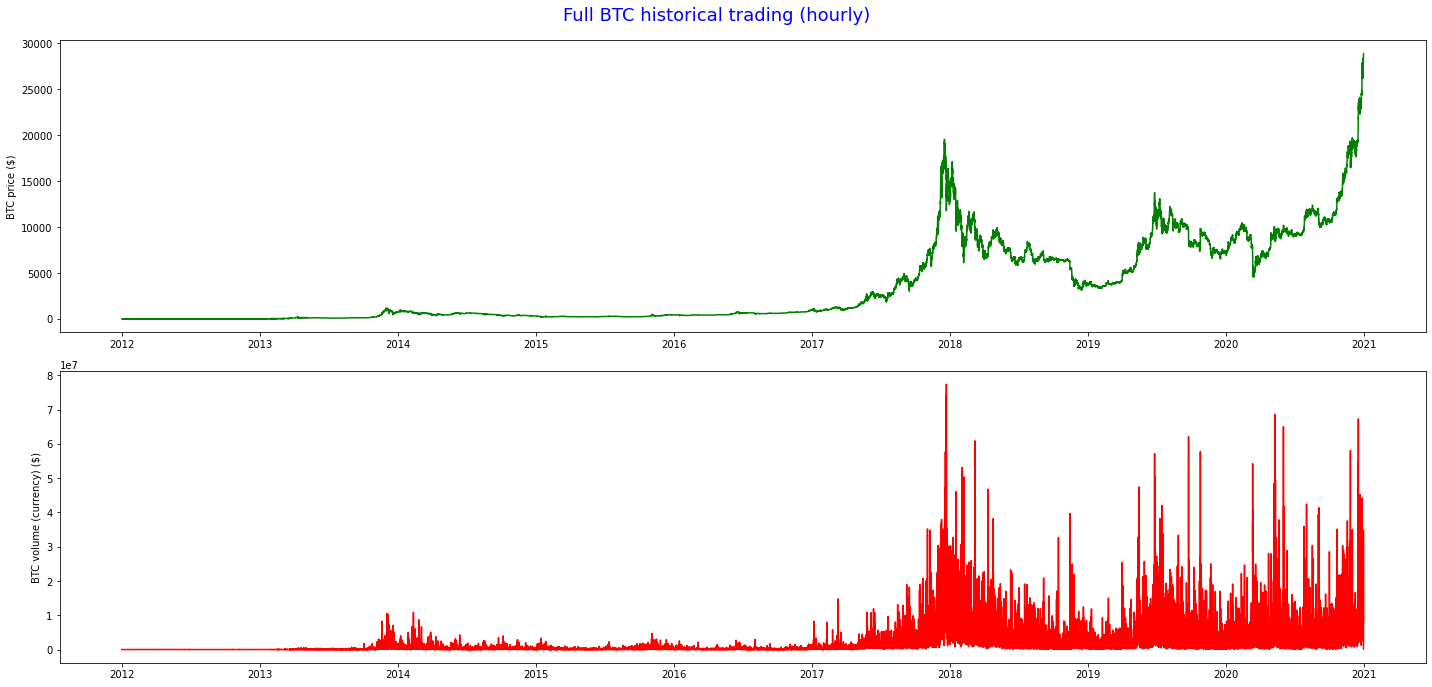

price NaN values:  Weighted_Price    3532
dtype: int64
volume NaN values:  Volume_(Currency)    0
dtype: int64


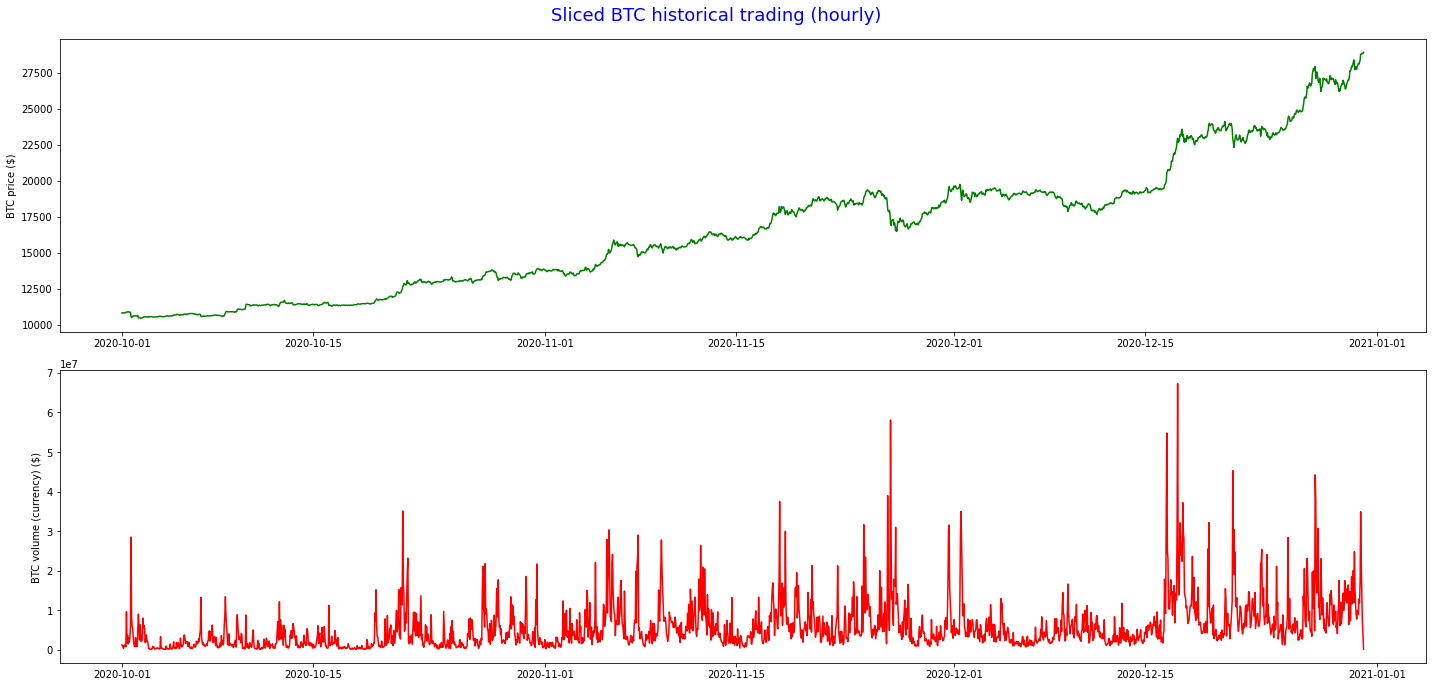

                     Weighted_Price  Volume_(Currency)
Timestamp                                             
2020-10-01 00:00:00    10802.577965       1.247691e+06
2020-10-01 01:00:00    10812.147072       1.165102e+06
2020-10-01 02:00:00    10825.511090       6.568092e+05
2020-10-01 03:00:00    10807.806794       3.931862e+05
2020-10-01 04:00:00    10813.231230       1.189855e+06


In [75]:
price = btc.resample('h', on='Timestamp')[['Weighted_Price']].mean()
volume_usd = btc.resample('h', on='Timestamp')[['Volume_(Currency)']].sum()
fig, axs = plt.subplots(2, 1, figsize=(20,10))
fig.suptitle('Full BTC historical trading (hourly)', fontsize= 18, color='b')
axs[0].plot(price, 'g')
axs[0].set_ylabel('BTC price ($)')
axs[1].plot(volume_usd, 'r')
axs[1].set_ylabel('BTC volume (currency) ($)')
#plt.setp(axs, xlim=[datetime.date(2017, 1, 26), datetime.date(2018, 2, 1)])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print('price NaN values: ',price.isna().sum())
print('volume NaN values: ',volume_usd.isna().sum())

# removed NaN and slice data
price.fillna(method ='bfill', inplace = True)
volume_usd.fillna(method ='bfill', inplace = True)
price = price[processing_from:processing_to]
volume_usd = volume_usd[processing_from:processing_to]
fig, axs = plt.subplots(2, 1, figsize=(20,10))
fig.suptitle('Sliced BTC historical trading (hourly)', fontsize= 18, color='b')
axs[0].plot(price, 'g')
axs[0].set_ylabel('BTC price ($)')
axs[1].plot(volume_usd, 'r')
axs[1].set_ylabel('BTC volume (currency) ($)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
btc = pd.concat([price, volume_usd], join = 'outer', axis = 1)
print(btc.head())

Define model Generator to create data for model

In [76]:
def BTC_forecasting_model(num_of_input_features, Tx, num_of_out_features, Ty, LSTM_units, LSTM_dropout, dropout_rate):
  model = Sequential()
  model.add(LSTM(LSTM_units, activation='relu', return_sequences=True, input_shape=(Tx, num_of_input_features), dropout=LSTM_dropout))
  model.add(Dropout(rate=dropout_rate))
  model.add(BatchNormalization())
  model.add(LSTM(LSTM_units, dropout=LSTM_dropout))
  model.add(Dropout(rate=dropout_rate))
  model.add(Dense(1, activation='sigmoid'))
  
  if optimizer == 'adam':
    opt = optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
    opt = optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss=cost_function, metrics=[MeanSquaredError()])
  return model

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               input_df,
               label_columns=None):
    # Store the raw data.
    self.input_df = input_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(input_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
def sequence_data_generator(df, label_columns, input_len, output_len, shift, batch_size):
  total_window_size = input_len + shift
  inputs = np.array(df)
  labels = np.array(df[label_columns])
  x_shape = (batch_size, input_len, inputs.shape[1])
  x_batch = np.zeros(shape=x_shape, dtype=np.float16)
  y_shape = (batch_size, output_len, 1)
  y_batch = np.zeros(shape=y_shape, dtype=np.float16)

  while True:
    for i in range(batch_size):
      idx = np.random.randint(len(inputs) - total_window_size)
      x_batch[i] = inputs[idx:idx+input_len]
      y_batch[i] = labels[idx + total_window_size-output_len:idx + total_window_size]
    yield (x_batch, y_batch)

Normalize data and split into train and test set.

In [77]:
columns_name = btc.columns
label_columns = [columns_name[0]]
scaler = preprocessing.MinMaxScaler()
btc_scaled = btc.copy()
scaler = scaler.fit(btc)
btc_scaled[columns_name] = scaler.transform(btc)
print(btc_scaled.head())
train, test = train_test_split(btc_scaled, test_size=0.2, random_state=1)
train, validate = train_test_split(train, test_size=0.25, random_state=1)
print('train len: ' + str(len(train)))

                     Weighted_Price  Volume_(Currency)
Timestamp                                             
2020-10-01 00:00:00        0.019344           0.017147
2020-10-01 01:00:00        0.019862           0.015917
2020-10-01 02:00:00        0.020586           0.008349
2020-10-01 03:00:00        0.019627           0.004424
2020-10-01 04:00:00        0.019921           0.016286
train len: 1311


Model, train and validate.

In [ ]:
model = BTC_forecasting_model(input_features, Tx, output_features, Ty, LSTM_units, LSTM_dropout, dropout_rate)
model.summary()

history = model.fit(sequence_data_generator(train, label_columns, Tx, Ty, shift, BATCH_SIZE),validation_data=sequence_data_generator(validate, label_columns, Tx, Ty, shift, BATCH_SIZE),validation_steps=len(validate)-Tx-shift, steps_per_epoch=len(train)-Tx-shift, epochs=num_epochs)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

predictions = model.predict(sequence_data_generator(test, label_columns, Tx, Ty, shift, len(test)-Tx-shift))
predictions = scaler.inverse_transform(predictions)
len(predictions)
print(predictions)
plt.plot(predictions)
plt.show()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 24, 128)           67072     
_________________________________________________________________
dropout_28 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 128)           512       
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 199,297
Trainable params: 199,041
Non-trainable params: 256
_____________________________________________